---
# Project 3 - Understanding User Behavior
### *By Jyoti Kumari* 

---

## Business Context
The Business team at a Game development company has come up with a game idea and requires support from the data science and data engineering team to build the pipeline for generating game events and tracking those events. The goal is to target interested users with a more minimal version and plan to launch the next version of game with enhanced features.  

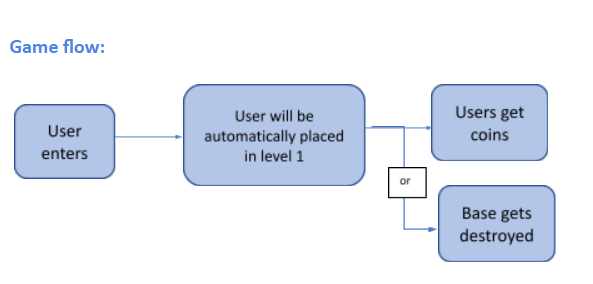

In [4]:
from IPython.display import Image
Image(filename='Images/Game_flow.png')

An App Server will be created to implement a game called`gameshop`. In this game, the user interacts with the game app, with the option to earn coins, upgrade their base or level up the game by spending the earned coins. These are the events that the data science team is interested in tracking:

1. add_coins
2. level_up
3. destroy_base

---
## Building the Pipeline
A data pipeline was created by the data engineering team to get ready for data scientists that work with the Business team so they can run queries on the data. The project goal is to prepare the infrastructure to land the data in the form and structure it needs to be to be queried - Presto will be used as a querying tool.

The following pipeline will be used:

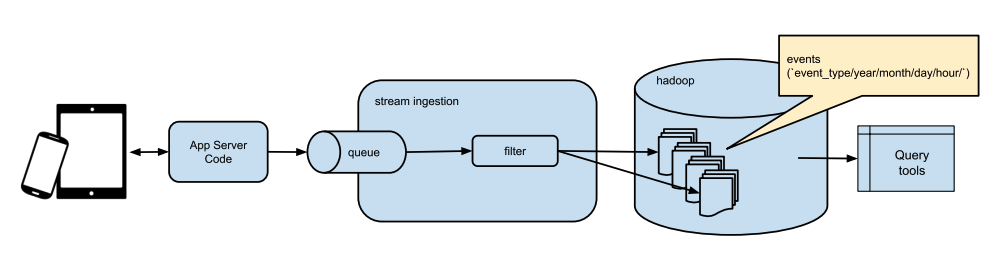

In [2]:
from IPython.display import Image
Image(filename='Images/data_pipeline.png')

On this pipeline, the API server process these requests and will process and log these game events to Kafka. Spark (a processing system) will be used to pull the events from Kafka. Spark helps us handle large amounts of data. Spark will be used to process the stream data filter the events, transform, agregate them, etc. and send them to a Hadoop file system. We will use Presto (a query engine) to run queries against our Hadoop File System. Presto will connect to Hive Metastore to gather the table names, location of the tables, and their schema.

Some of the commands and files used for the above pipeline are described below:

#### docker-compose.yml
The docker compose file, shown below, has six services: **Zookeeper, Kafka, Cloudera, Spark, Presto, and Mids.** Zookeeper is the manager for Kafka. It keeps track of what's happening with the Kafka brokers. Kafka connects with Zookeeper on port "32181". Cloudera contains the Hadoop file system, and exposes on ports "9083" and "10000" for Hive thrift and jdbc respectively. Spark pulls the events from Kafka. Spark depends on cloudera, and it has two environments: HADOOP_NAMENODE: Cloudera and HIVE_TRIFTSERVER: cloudera:9083. Presto talks to the HIVE_TRIFTSERVER and queries data from the Hadoop File System. The MIDS container holds the flask implementation.

```
---
version: '2'
services:
  zookeeper:
    image: confluentinc/cp-zookeeper:latest
    environment:
      ZOOKEEPER_CLIENT_PORT: 32181
      ZOOKEEPER_TICK_TIME: 2000
    expose:
      - "2181"
      - "2888"
      - "32181"
      - "3888"
    extra_hosts:
      - "moby:127.0.0.1"

  kafka:
    image: confluentinc/cp-kafka:latest
    depends_on:
      - zookeeper
    environment:
      KAFKA_BROKER_ID: 1
      KAFKA_ZOOKEEPER_CONNECT: zookeeper:32181
      KAFKA_ADVERTISED_LISTENERS: PLAINTEXT://kafka:29092
      KAFKA_OFFSETS_TOPIC_REPLICATION_FACTOR: 1
    expose:
      - "9092"
      - "29092"
    extra_hosts:
      - "moby:127.0.0.1"

  cloudera:
    image: midsw205/hadoop:0.0.2
    hostname: cloudera
    expose:
      - "8020" # nn
      - "8888" # hue
      - "9083" # hive thrift
      - "10000" # hive jdbc
      - "50070" # nn http
    ports:
      - "8888:8888"
    extra_hosts:
      - "moby:127.0.0.1"

  spark:
    image: midsw205/spark-python:0.0.6
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205
    expose:
      - "8888"
    ports:
      - "8889:8888" # 8888 conflicts with hue
    depends_on:
      - cloudera
    environment:
      HADOOP_NAMENODE: cloudera
      HIVE_THRIFTSERVER: cloudera:9083
    extra_hosts:
      - "moby:127.0.0.1"
    command: bash

  presto:
    image: midsw205/presto:0.0.1
    hostname: presto
    volumes:
      - ~/w205:/w205
    expose:
      - "8080"
    environment:
      HIVE_THRIFTSERVER: cloudera:9083
    extra_hosts:
      - "moby:127.0.0.1"

  mids:
    image: midsw205/base:0.1.9
    stdin_open: true
    tty: true
    volumes:
      - ~/w205:/w205
    expose:
      - "5000"
    ports:
      - "5000:5000"
    extra_hosts:
      - "moby:127.0.0.1"

```

**Spin up the cluster:**

```
docker-compose up -d

docker-compose logs -f kafka #to check the logs files for kafka

```

**Check out Hadoop:**

Look at tmp/ dir in hdfs and see that what we want to write isn't there already.

```
docker-compose exec cloudera hadoop fs -ls /tmp/

At this point, there should not be any files written to HDFS, except the root files.

Found 2 items
drwxrwxrwt   - mapred mapred          0 2016-04-06 02:26 /tmp/hadoop-yarn
drwxrwxrwt   - mapred hadoop          0 2016-04-06 02:28 /tmp/logs
```

### Create a web-based application: Flask app

#### game_api_p3.py

This file, shown below contains the game API. On this Python script, we import Kafka producer that will allow us to send data to Kafka on port 29092. We import Flask and create the Flask APP. The script also has a function that logs things to Kafka, and we log a topic and an event. We create a json object (json dumps) from the string. We have three different event types: add coins, level up, and destroy . In addition to this we have a default event too. In this particular pipeline, we will be using data from all three events.

```
#!/usr/bin/env python
import json
from kafka import KafkaProducer
from flask import Flask, request

app = Flask(__name__)
producer = KafkaProducer(bootstrap_servers='kafka:29092')


def log_to_kafka(topic, event):
    event.update(request.headers)
    producer.send(topic, json.dumps(event).encode())


@app.route("/")
def default_response():
    default_event = {'event_type': 'default'}
    log_to_kafka('events', default_event)
    return "This is the default response!\n"


@app.route("/level_up")
def level_up():
    level_Up_event = {'event_type': 'level_up'}
    log_to_kafka('events', level_Up_event)
    return "You have moved up a level!\n"


@app.route("/add_coins")
def add_coins():
    add_coins_event = {'event_type': 'add_coins'}
    log_to_kafka('events', add_coins_event)
    return "You earned coins!\n"


@app.route("/destroy_base")
def destroy_base():
    destroy_base_event = {'event_type': 'destroy_base'}
    log_to_kafka('events', destroy_base_event)
    return "Base is destroyed!\n"

```

### Run Flask
```
docker-compose exec mids env FLASK_APP=/w205/Project3/game_api_p3.py flask run --host 0.0.0.0
```
The "-- host 0.0.0.0" command opens the last server to accept connections from outside the local host

Output:
```
 * Serving Flask app "game_api_p3"
 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
```

FLask is running in the local host, and we know we need to connect on port 5000 to send and get requests.

### Create a topic "events"

```
docker-compose exec kafka kafka-topics --create --topic events --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```

Output:

```
Created topic events
```

### Check the topic

```
docker-compose exec kafka \
  kafka-topics \
    --describe \
    --topic events \
    --zookeeper zookeeper:32181
    
Output:

Topic: events   PartitionCount: 1       ReplicationFactor: 1    Configs: 
        Topic: events   Partition: 0    Leader: 1       Replicas: 1     Isr: 1
```

### Read from kafka (Set up to watch kafka)

Use kafkacat to consume events from the `events` topic

```
docker-compose exec mids bash -c "kafkacat -C -b kafka:29092 -t events -o beginning"
```

- Leave the terminal window open
- running kafkacat without -e so it will run continuously
- Open another terminala window

### Create the data 

Create data by connecting to our game ourselves from within the mids container to test that kafka is watching our events

- Run on separate terminal 

We can use curl to send data using the following code:

```
docker-compose exec mids curl http://localhost:5000/
docker-compose exec mids curl http://localhost:5000/level_up
docker-compose exec mids curl http://localhost:5000/add_coins
docker-compose exec mids curl http://localhost:5000/destroy_base
```        

Output:

```
{"Host": "localhost:5000", "event_type": "default", "Accept": "*/*", "User-Agent": "curl/7.47.0"}
{"Host": "localhost:5000", "event_type": "level_up", "Accept": "*/*", "User-Agent": "curl/7.47.0"}
{"Host": "localhost:5000", "event_type": "add_coins", "Accept": "*/*", "User-Agent": "curl/7.47.0"}
{"Host": "localhost:5000", "event_type": "destroy_base", "Accept": "*/*", "User-Agent": "curl/7.47.0"}
```

back on the terminal we are running Flask, we can see the GET requests:

```
127.0.0.1 - - [11/Apr/2021 06:14:15] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2021 06:14:36] "GET /level_up HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2021 06:14:48] "GET /add_coins HTTP/1.1" 200 -
127.0.0.1 - - [11/Apr/2021 06:14:54] "GET /destroy_base HTTP/1.1" 200 -
```

http is the protocol, 1.1 is the version. The 200 number corresponds with the status code. 404 is the response when an unexisting item is requested.

#### We can also use Apache Bench (benchmarking tool):

```
docker-compose exec mids ab -n 10 -H "Host: user1.gameshop.com" http://localhost:5000/level_up
docker-compose exec mids ab -n 10 -H "Host: user1.gameshop.com" http://localhost:5000/add_coins
docker-compose exec mids ab -n 10 -H "Host: user1.gameshop.com" http://localhost:5000/destroy_base

```

We are creating 10 events at once, with the command -H it allows us to manipulate the Host string.

### Create Stream data

#### write_events_stream_p3.py


```
Extract events from Kafkfa and write them to HDFS
#!/usr/bin/env python
"""Extract events from kafka and write them to hdfs
"""
import json
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, from_json
from pyspark.sql.types import StructType, StructField, StringType


def level_up_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
    ])


@udf('boolean')
def is_level_up(event_as_json):
    """udf for filtering events
    """
    event = json.loads(event_as_json)
    if event['event_type'] == 'level_up':
        return True
    return False


def add_coins_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
    ])


@udf('boolean')
def is_add_coins(event_as_json):
    """udf for filtering events
    """
    event = json.loads(event_as_json)
    if event['event_type'] == 'add_coins':
        return True
    return False


def destroy_base_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- timestamp: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
    ])


@udf('boolean')
def is_destroy_base(event_as_json):
    """udf for filtering events
    """
    event = json.loads(event_as_json)
    if event['event_type'] == 'destroy_base':
        return True
    return False

def main():
    """main
    """
    spark = SparkSession \
        .builder \
        .appName("ExtractEventsJob") \
        .getOrCreate()

    raw_events = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "kafka:29092") \
        .option("subscribe", "events") \
        .load()

    level_up = raw_events \
        .filter(is_level_up(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          level_up_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')

    add_coins = raw_events \
        .filter(is_add_coins(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          add_coins_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')

    destroy_base = raw_events \
        .filter(is_destroy_base(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          destroy_base_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')   

    sink1 = level_up \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_level_up_events") \
        .option("path", "/tmp/level_up_events") \
        .trigger(processingTime="10 seconds") \
        .start()

    sink2 = add_coins \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_add_coins_events") \
        .option("path", "/tmp/add_coins_events") \
        .trigger(processingTime="10 seconds") \
        .start()

    sink3 = destroy_base \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_destroy_base_events") \
        .option("path", "/tmp/destroy_base_events") \
        .trigger(processingTime="10 seconds") \
        .start()

    sink1.awaitTermination()
    sink2.awaitTermination()
    sink3.awaitTermination()


if __name__ == "__main__":
    main()

```

### Run it and submit to Spark

```
docker-compose exec spark spark-submit /w205/project-3-ginnyp/write_events_stream_p3.py
```

::: notes
wait a bit for the first stream interval to finish saving data
:::

### Check what it wrote to Hadoop in a separate terminal

```
docker-compose exec cloudera hadoop fs -ls /tmp

```
Output:
```

Found 9 items
drwxr-xr-x   - root   supergroup          0 2021-04-11 08:55 /tmp/add_coin_events
drwxrwxrwt   - root   supergroup          0 2021-04-11 08:55 /tmp/checkpoints_for_add_coin_events
drwxrwxrwt   - root   supergroup          0 2021-04-11 08:55 /tmp/checkpoints_for_destroy_base_events
drwxrwxrwt   - root   supergroup          0 2021-04-11 08:55 /tmp/checkpoints_for_level_up_events
drwxr-xr-x   - root   supergroup          0 2021-04-11 08:55 /tmp/destroy_base_events
drwxrwxrwt   - mapred mapred              0 2016-04-06 02:26 /tmp/hadoop-yarn
drwx-wx-wx   - hive   supergroup          0 2021-04-11 08:55 /tmp/hive
drwxr-xr-x   - root   supergroup          0 2021-04-11 08:55 /tmp/level_up_events
drwxrwxrwt   - mapred hadoop              0 2016-04-06 02:28 /tmp/logs
```



### Set up Presto

#### Hive metastore

- Run Hive in the Hadoop container
```
docker-compose exec cloudera hive
```

#### Create tables in hive

- We are creating 3 tables here as listed below:

1) level_up_events

2) add_coins_events

3) destroy_base_events

```
hive> 
create external table if not exists default.level_up_events (
    raw_event string,
    timestamp string,
    Accept string,
    Host string,
    User_Agent string,
    event_type string
    
  )
  stored as parquet 
  location '/tmp/level_up_events'
  tblproperties ("parquet.compress"="SNAPPY");

hive>
create external table if not exists default.add_coins_events (
    raw_event string,
    timestamp string,
    Accept string,
    Host string,
    User_Agent string,
    event_type string
    
  )
  stored as parquet 
  location '/tmp/add_coins_events'
  tblproperties ("parquet.compress"="SNAPPY");
  

hive>
create external table if not exists default.destroy_base_events (
    raw_event string,
    timestamp string,
    Accept string,
    Host string,
    User_Agent string,
    event_type string
    
  )
  stored as parquet 
  location '/tmp/destroy_base_events'
  tblproperties ("parquet.compress"="SNAPPY");

```

and then `ctrl-D` to exit the hive shell


---
## Querying data

### Query with presto

```
docker-compose exec presto presto --server presto:8080 --catalog hive --schema default
```

### What tables do we have in Presto?

```
presto:default> show tables;
```
Output:

```
       Table        
---------------------
 add_coins_events    
 destroy_base_events 
 level_up_events     
(3 rows)

```

### Describe tables

```
presto:default> describe add_coins_events;
presto:default> describe level_up_events;
presto:default> describe destroy_base_events;

```



Ouput:

```
   Column   |  Type   | Comment 
------------+---------+---------
 raw_event  | varchar |         
 timestamp  | varchar |         
 accept     | varchar |         
 host       | varchar |         
 user_agent | varchar |         
 event_type | varchar |         
(6 rows)


```

### Query tables

```
presto:default> select * from add_coins_events;
presto:default> select * from level_up_events;
presto:default> select * from destroy_base_events;


presto:default> select * from add_coins_events;
 raw_event | timestamp | accept | host | user_agent | event_type 
-----------+-----------+--------+------+------------+------------
(0 rows)


presto:default> select * from level_up_events;
 raw_event | timestamp | accept | host | user_agent | event_type 
-----------+-----------+--------+------+------------+------------
(0 rows)


presto:default> select count(*) from destroy_base_events;
 raw_event | timestamp | accept | host | user_agent | event_type 
-----------+-----------+--------+------+------------+------------
(0 rows)

```



### More data

#### Feed the stream more data

Run this script `python3 stream-events_script_p3.py` to randomly generate events for 5 different users and send them to Hadoop for querying through presto

- Run in a separate terminal > python3 stream-events_script_p3.py


```
--------------------
while true; do
  docker-compose exec mids \
    ab -n 10 -H "Host: user1.gameshop.com" \
      http://localhost:5000/add_coins
  sleep 10
done
----------------------
while true; do
  docker-compose exec mids \
    ab -n 10 -H "Host: user2.gameshop.com" \
      http://localhost:5000/level_up
  sleep 10
done
------------------------
while true; do
  docker-compose exec mids \
    ab -n 10 -H "Host: user3.gameshop.com" \
      http://localhost:5000/destroy_base
  sleep 10
done
-----------------
```

### watch table grow

#### Count the number of records on the tables
```
presto:default> select count(*) from add_coins_events;
presto:default> select count(*) from level_up_events;
presto:default> select count(*) from destroy_base_events;

```

```
presto:default> select count(*) from add_coins_events;
 _col0 
-------
   580 
(1 row)


presto:default> select count(*) from level_up_events;
 _col0 
-------
   420 
(1 row)


presto:default> select count(*) from destroy_base_events;
 _col0 
-------
   380 
(1 row)

```

---
## Business Question
**Question 1: Break down the `level_up_events` by Host?**


`Query:`

select Host, count(*) from level_up_events group by Host; 

`Output:`

```
presto:default> select Host, count(*) from level_up_events group by Host; 

        Host        | _col1 
--------------------+-------
 user2.gameshop.com |    30 
 user1.gameshop.com |    20 
 user5.gameshop.com |    30 
(3 rows)

```

**Question 2: Which hosts had the most users?**

`Query:`

select Host, sum(1) as max_users from level_up_events group by Host order by max_users DESC; 

`Output:`

```
presto:default> select Host, sum(1) as max_users from level_up_events group by Host order by max_users DESC; 

        Host        | max_users 
--------------------+-------
 user1.gameshop.com |    2780 
 user5.gameshop.com |    120 
 user3.gameshop.com |    90 
 user2.gameshop.com |    60 
 user4.gameshop.com |    50 
(5 rows)

```
**Question 3: What is the earliest day and time that a user played the game?**

`Query:`

select max(timestamp) from add_coin_events; 

`Output:`

```
presto:default> max(timestamp) from add_coin_events;

 _col0      
-------
2021-04-16 06:10:36.47
(1 row)
```

**Question 4: When is the last time a user logged in?:**

`Query:`

select min(timestamp) from level_up_events; 

`Output:`

```
presto:default> min(timestamp) from level_up_events;

 _col0      
-------
2021-04-16 14:10:36.47
(1 row)
```

---
## Bring Docker Down
```
docker-compose down
```
---